

**Datasets**: `chefmozaccepts.csv`, `chefmozcuisine.csv`, `chefmozhours4.csv`, `chefmozparking.csv`, `geoplaces2.csv`, `usercuisine.csv`, `userpayment.csv`, `userprofile.csv`, `rating_final.csv`.

In [3]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import os

# Pretty display for notebooks
%matplotlib inline

In [5]:


def load_dataset(file_name):
    try:
        df = pd.read_csv( file_name)
        print(f'{file_name} has {df.shape[0]} samples with {df.shape[1]} features each.')
        return df
    except:
        print(f'{file_name} could not be loaded. Is the dataset missing?')
        return None

print('Loading restaurant datasets')
rest_pay = load_dataset('chefmozaccepts.csv')
rest_cuisine = load_dataset('chefmozcuisine.csv')
rest_hours = load_dataset('chefmozhours4.csv')
rest_parking = load_dataset('chefmozparking.csv')
rest_geo = load_dataset('geoplaces2.csv')

print('\nLoading consumer datasets')
cons_cuisine = load_dataset('usercuisine.csv')
cons_pay = load_dataset('userpayment.csv')
cons_profile = load_dataset('userprofile.csv')

print('\nLoading User-Item-Rating dataset')
rating = load_dataset('rating_final.csv')

Loading restaurant datasets
chefmozaccepts.csv has 1314 samples with 2 features each.
chefmozcuisine.csv has 916 samples with 2 features each.
chefmozhours4.csv has 2339 samples with 3 features each.
chefmozparking.csv has 702 samples with 2 features each.
geoplaces2.csv has 130 samples with 21 features each.

Loading consumer datasets
usercuisine.csv has 330 samples with 2 features each.
userpayment.csv has 177 samples with 2 features each.
userprofile.csv has 138 samples with 19 features each.

Loading User-Item-Rating dataset
rating_final.csv has 1161 samples with 5 features each.


## Data Exploration
We explore the datasets to understand their structure and relationships.

**Restaurant datasets**:
- rest_pay: `placeID`, `Rpayment`
- rest_cuisine: `placeID`, `Rcuisine`
- rest_hours: `placeID`, `hours`, `days`
- rest_parking: `placeID`, `parking_lot`
- rest_geo: `placeID`, `latitude`, `longitude`, `name`, `price`, `alcohol`, `Rambience`, etc.

**User datasets**:
- cons_pay: `userID`, `Upayment`
- cons_cuisine: `userID`, `Rcuisine`
- cons_profile: `userID`, `latitude`, `longitude`, `smoker`, `drink_level`, `budget`, etc.

**Rating dataset**:
- rating: `userID`, `placeID`, `rating`, `food_rating`, `service_rating`

In [6]:
# Check number of unique users in ratings
list_users = rating['userID'].unique()
print(f'Number of users who rated restaurants: {len(list_users)}')

# Check number of unique users in profile
users = cons_profile['userID'].unique()
print(f'Number of users in profile: {len(users)}')

# Remove users from cons_profile who haven't rated
cons_profile = cons_profile[cons_profile['userID'].isin(list_users)]
print(f'Number of users in cons_profile without ratings: {len(users) - len(cons_profile)}')

Number of users who rated restaurants: 138
Number of users in profile: 138
Number of users in cons_profile without ratings: 0


## Data Visualization


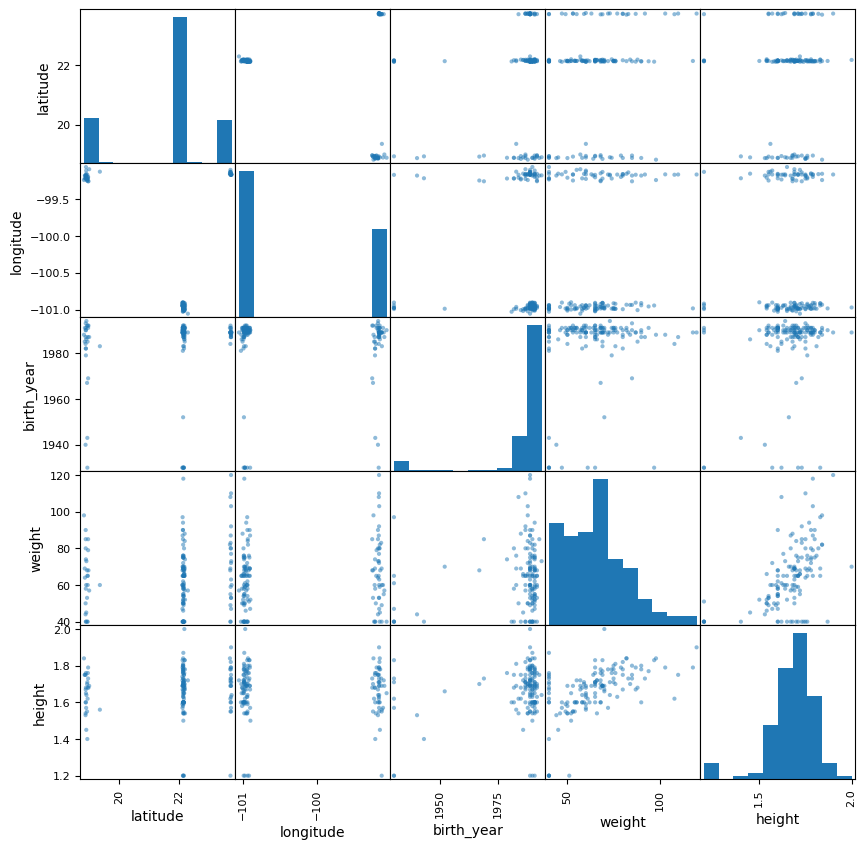

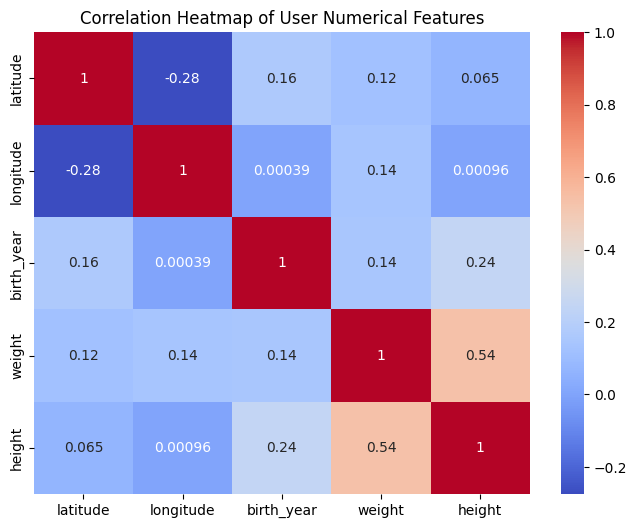

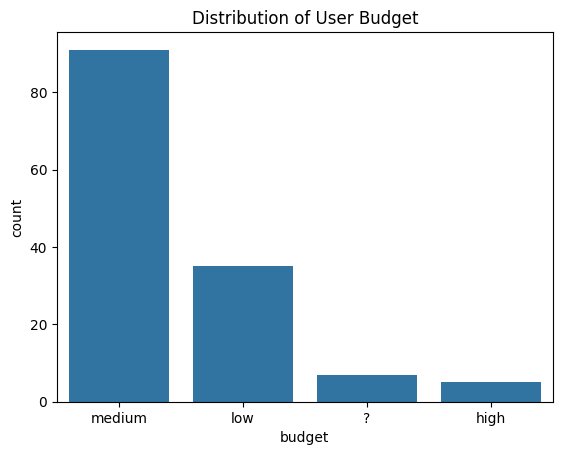

In [7]:
# Scatter matrix for numerical features
pd.plotting.scatter_matrix(cons_profile[['latitude', 'longitude', 'birth_year', 'weight', 'height']], figsize=(10, 10))
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cons_profile[['latitude', 'longitude', 'birth_year', 'weight', 'height']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of User Numerical Features')
plt.show()

# Bar plot for categorical feature: budget
sns.countplot(data=cons_profile, x='budget')
plt.title('Distribution of User Budget')
plt.show()

## Hybrid Recommendation System
- **Collaborative Filtering (CF)**: Compute cosine similarity on the user-item rating matrix to predict ratings.
- **Content-Based Filtering (CBF)**: Use restaurant and user features (e.g., cuisine, price, budget) to compute similarity scores.
- **Hybrid**: Combine CF and CBF scores with weights (0.6 for CF, 0.4 for CBF).

allowing users to input a `userID`.

In [10]:
# 1. Collaborative Filtering (CF)
# Create user-item rating matrix
rating_matrix = rating.pivot(index='userID', columns='placeID', values='rating').fillna(0)

# Compute cosine similarity between users
user_similarity = cosine_similarity(rating_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

# Predict CF scores
def predict_cf_scores(rating_matrix, user_similarity_df):
    # Normalize similarity to avoid division by zero
    sim_sums = user_similarity_df.abs().sum(axis=1).replace(0, 1)
    # Compute weighted average of ratings
    pred_scores = np.dot(user_similarity_df, rating_matrix) / sim_sums.values[:, np.newaxis]
    return pd.DataFrame(pred_scores, index=rating_matrix.index, columns=rating_matrix.columns)

cf_scores = predict_cf_scores(rating_matrix, user_similarity_df)

# 2. Content-Based Filtering (CBF)
# Create restaurant profiles
rest_features = rest_geo[['placeID', 'price', 'alcohol', 'Rambience']].merge(
    rest_cuisine[['placeID', 'Rcuisine']], on='placeID', how='left'
)
rest_features['Rcuisine'] = rest_features['Rcuisine'].fillna('Unknown')

# Create user features based on rated restaurants
user_ratings = rating[rating['rating'] > 1][['userID', 'placeID']]  # High ratings
user_features = user_ratings.merge(rest_features, on='placeID')

# Use a single OneHotEncoder for both rest_features and user_features
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
feature_columns = ['price', 'alcohol', 'Rambience', 'Rcuisine']

# Fit encoder on all possible feature values (from rest_features)
encoder.fit(rest_features[feature_columns])

# Encode restaurant features
encoded_rest_features = encoder.transform(rest_features[feature_columns])
item_profiles = pd.DataFrame(encoded_rest_features, index=rest_features['placeID'])

# Encode user features (only if user_features is not empty)
if not user_features.empty:
    encoded_user_features = encoder.transform(user_features[feature_columns])
    encoded_user_features_df = pd.DataFrame(encoded_user_features, index=user_features.index)
    encoded_user_features_df['userID'] = user_features['userID']
    user_profiles = encoded_user_features_df.groupby('userID').mean()
else:
    print("Warning: No user features available (no ratings > 1). Using empty user_profiles.")
    user_profiles = pd.DataFrame(columns=item_profiles.columns, index=rating_matrix.index)

# Verify column alignment
if user_profiles.shape[1] != item_profiles.shape[1]:
    print(f"Error: user_profiles has {user_profiles.shape[1]} columns, item_profiles has {item_profiles.shape[1]} columns.")
    # Align columns by reindexing user_profiles to match item_profiles
    user_profiles = user_profiles.reindex(columns=item_profiles.columns, fill_value=0)

# Handle NaN/inf values
user_profiles = user_profiles.fillna(0).replace([np.inf, -np.inf], 0)
item_profiles = item_profiles.fillna(0).replace([np.inf, -np.inf], 0)

# Compute CBF scores using cosine similarity
cbf_scores = cosine_similarity(user_profiles, item_profiles)
cbf_scores_df = pd.DataFrame(cbf_scores, index=user_profiles.index, columns=item_profiles.index)

# Normalize CBF scores to match CF scale (0-2)
cbf_scores_df = 2 * (cbf_scores_df - cbf_scores_df.min()) / (cbf_scores_df.max() - cbf_scores_df.min())

# 3. Hybrid: Combine CF and CBF scores
hybrid_scores = 0.6 * cf_scores + 0.4 * cbf_scores_df.reindex(cf_scores.index).fillna(0)

# 4. Generate recommendations
def get_recommendations(user_id, hybrid_scores, rest_geo, top_k=10):
    if user_id not in hybrid_scores.index:
        print(f'User {user_id} not found.')
        return None
    recommendations = hybrid_scores.loc[user_id].sort_values(ascending=False).head(top_k)
    
    # Loại bỏ index trùng trong recommendations nếu có
    recommendations = recommendations[~recommendations.index.duplicated()]
    
    # Lọc rest_geo và loại bỏ trùng placeID
    result = rest_geo[rest_geo['placeID'].isin(recommendations.index)].drop_duplicates(subset=['placeID']).copy()
    
    # Map điểm recommendation dựa trên placeID
    result['Recommendation Score'] = result['placeID'].map(recommendations)
    return result


# Interactive user input
user_id = input('Enter userID (e.g., U1119): ')
top_recommendations = get_recommendations(user_id, hybrid_scores, rest_geo)
if top_recommendations is not None:
    print(f'Top 10 recommended restaurants for user {user_id}:')
    print(top_recommendations)

Enter userID (e.g., U1119):  U1119


Top 10 recommended restaurants for user U1119:
     placeID   latitude   longitude  \
26    132768  18.925773  -99.232636   
38    134992  18.936683  -99.247366   
48    135001  18.941859  -99.241927   
51    135000  18.870565  -99.226938   
90    132872  22.173596 -100.994603   
98    132767  18.882087  -99.163027   
100   134996  18.923429  -99.216413   
112   134986  18.928798  -99.239513   
114   132766  18.910178  -99.231544   
124   132583  18.922290  -99.234332   

                                        the_geom_meter  \
26   0101000020957F000000DD3546816E5AC119D4BD17FD54...   
38   0101000020957F0000FC799354656C5AC1233FCC70E758...   
48   0101000020957F0000429477F3B36B5AC1D65C45CAFA56...   
51   0101000020957F00001CCDD2577A775AC1D25FB8BA1F56...   
90   0101000020957F0000942C3434384458C1C2D3499804A7...   
98   0101000020957F00001672C2C435775AC1F69BF2EF0D42...   
100  0101000020957F0000340233E7476F5AC132844E2A2C50...   
112  0101000020957F00002A0D05E2D96D5AC1AB058CB1EC56...   
1

## Evaluation
 evaluate the hybrid system using RMSE and precision@K on a test set.

In [11]:
# Split data into train and test (80-20)
np.random.seed(42)
test_indices = np.random.choice(rating.index, size=int(0.2 * len(rating)), replace=False)
test_set = rating.loc[test_indices]
train_set = rating.drop(test_indices)

# Recreate rating matrix for training
train_rating_matrix = train_set.pivot(index='userID', columns='placeID', values='rating').fillna(0)
train_user_similarity = cosine_similarity(train_rating_matrix)
train_user_similarity_df = pd.DataFrame(train_user_similarity, index=train_rating_matrix.index, columns=train_rating_matrix.index)
train_cf_scores = predict_cf_scores(train_rating_matrix, train_user_similarity_df)

# RMSE
predictions = []
true_ratings = []
for _, row in test_set.iterrows():
    user_id, item_id, true_rating = row['userID'], row['placeID'], row['rating']
    if user_id in hybrid_scores.index and item_id in hybrid_scores.columns:
        pred_score = hybrid_scores.loc[user_id, item_id]
        # Ensure pred_score and true_rating are numeric
        if isinstance(pred_score, (int, float)) and isinstance(true_rating, (int, float)):
            predictions.append(float(pred_score))
            true_ratings.append(float(true_rating))

if predictions:  # Ensure predictions list is not empty
    rmse = np.sqrt(mean_squared_error(true_ratings, predictions))
    print(f'RMSE: {rmse:.4f}')
else:
    print('No valid predictions for RMSE calculation. Check if hybrid_scores contains test set userIDs and placeIDs.')

# Precision@K
K = 10
precision_sum = 0
user_count = 0
for user_id in list_users:
    if user_id in hybrid_scores.index:
        user_recs = hybrid_scores.loc[user_id].sort_values(ascending=False).head(K).index
        relevant_items = rating[(rating['userID'] == user_id) & (rating['rating'] > 1)]['placeID']
        hits = len(set(user_recs).intersection(set(relevant_items)))
        precision_sum += hits / K
        user_count += 1

if user_count > 0:
    precision_at_k = precision_sum / user_count
    print(f'Precision@{K}: {precision_at_k:.4f}')
else:
    print(f'No users with valid recommendations for Precision@{K} calculation.')

RMSE: 0.6794
Precision@10: 0.2935
